In [16]:
import torch
from torch.functional import norm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from pathlib import Path
from datamaestro import prepare_dataset
import time
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
BATCH_SIZE = 311
TRAIN_RATIO = 0.8
LOG_PATH = "/tmp/runs/lightning_logs"


In [10]:

class Lit2Layer(pl.LightningModule):
    def __init__(self,dim_in,l,dim_out,learning_rate=1e-3):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in,l),nn.ReLU(),nn.Linear(l,dim_out))
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.name = "exemple-lightning"
        self.valid_outputs = []
        self.training_outputs = []

    def forward(self,x):
        """ Définit le comportement forward du module"""
        x = self.model(x)
        return x

    def configure_optimizers(self):
        """ Définit l'optimiseur """
        optimizer = torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        return optimizer

    def training_step(self,batch,batch_idx):
        """ une étape d'apprentissage
        doit retourner soit un scalaire (la loss),
        soit un dictionnaire qui contient au moins la clé 'loss'"""
        x, y = batch
        yhat= self(x) ## equivalent à self.model(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        self.log("accuracy",acc/len(x),on_step=False,on_epoch=True)
        self.valid_outputs.append({"loss":loss,"accuracy":acc,"nb":len(x)})
        return logs

    def validation_step(self,batch,batch_idx):
        """ une étape de validation
        doit retourner un dictionnaire"""
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        self.log("val_accuracy", acc/len(x),on_step=False,on_epoch=True)
        self.valid_outputs.append({"loss":loss,"accuracy":acc,"nb":len(x)})
        return logs

    def test_step(self,batch,batch_idx):
        """ une étape de test """
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        return logs

    def log_x_end(self,outputs,phase):
        total_acc = sum([o['accuracy'] for o in outputs])
        total_nb = sum([o['nb'] for o in outputs])
        total_loss = sum([o['loss'] for o in outputs])/len(outputs)
        total_acc = total_acc/total_nb
        self.log_dict({f"loss/{phase}":total_loss,f"acc/{phase}":total_acc})
        #self.logger.experiment.add_scalar(f'loss/{phase}',total_loss,self.current_epoch)
        #self.logger.experiment.add_scalar(f'acc/{phase}',total_acc,self.current_epoch)

    def on_training_epoch_end(self):
        """ hook optionel, si on a besoin de faire quelque chose apres une époque d'apprentissage.
        Par exemple ici calculer des valeurs à logger"""
        self.log_x_end(self.training_outputs,'train')
        self.training_outputs.clear()
        # Le logger de tensorboard est accessible directement avec self.logger.experiment.add_XXX
    def on_validation_epoch_end(self):
        """ hook optionel, si on a besoin de faire quelque chose apres une époque de validation."""
        self.log_x_end(self.valid_outputs,'valid')
        self.valid_outputs.clear()

    def on_test_epoch_end(self):
        pass


In [11]:
class LitMnistData(pl.LightningDataModule):

    def __init__(self,batch_size=BATCH_SIZE,train_ratio=TRAIN_RATIO):
        super().__init__()
        self.dim_in = None
        self.dim_out = None
        self.batch_size = batch_size
        self.train_ratio = train_ratio

    def prepare_data(self):
        ### Do not use "self" here.
        prepare_dataset("com.lecun.mnist")

    def setup(self,stage=None):
        ds = prepare_dataset("com.lecun.mnist")
        if stage =="fit" or stage is None:
            # Si on est en phase d'apprentissage
            shape = ds.train.images.data().shape
            self.dim_in = shape[1]*shape[2]
            self.dim_out = len(set(ds.train.labels.data()))
            ds_train = TensorDataset(torch.tensor(ds.train.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.train.labels.data()).long())
            train_length = int(shape[0]*self.train_ratio)
            self.mnist_train, self.mnist_val, = random_split(ds_train,[train_length,shape[0]-train_length])
        if stage == "test" or stage is None:
            # en phase de test
            self.mnist_test= TensorDataset(torch.tensor(ds.test.images.data()).view(-1,self.dim_in).float()/255., torch.tensor(ds.test.labels.data()).long())

    def train_dataloader(self):
        return DataLoader(self.mnist_train,batch_size=self.batch_size)
    def val_dataloader(self):
        return DataLoader(self.mnist_val,batch_size=self.batch_size)
    def test_dataloader(self):
        return DataLoader(self.mnist_test,batch_size=self.batch_size)





In [5]:
data = LitMnistData()
data.prepare_data()


In [12]:
data.setup()

In [13]:
train_loader = data.train_dataloader()
val_loader  = data.val_dataloader()
test_loader = data.test_dataloader()

In [14]:
for x, y in train_loader: 
    print(x.size(), y.size())
    break

torch.Size([311, 784]) torch.Size([311])


In [12]:
model = Lit2Layer(data.dim_in,10,data.dim_out,learning_rate=1e-3)
logger = TensorBoardLogger(save_dir=LOG_PATH,name=model.name,version=time.asctime(),default_hp_metric=False)
trainer = pl.Trainer(
    default_root_dir=LOG_PATH,
    logger=logger,
    max_epochs=100,
)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
#trainer.fit(model,train_loader)
#trainer.test(model,test_loader)

NameError: name 'trainer' is not defined

In [40]:
# Model
class Model2LP(nn.Module):
    def __init__(self,dim_in,l,dim_out,learning_rate=1e-3):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(dim_in,l),nn.ReLU(),nn.Linear(l,dim_out))
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.name = "2 Layers Perceptron"
        self.valid_outputs = []
        self.training_outputs = []

    def forward(self,x):
        """ Définit le comportement forward du module"""
        x = self.model(x)
        return x

    def configure_optimizers(self):
        """ Définit l'optimiseur """
        optimizer = torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        return optimizer

    def training_step(self,batch,batch_idx):
        """ une étape d'apprentissage
        doit retourner soit un scalaire (la loss),
        soit un dictionnaire qui contient au moins la clé 'loss'"""
        x, y = batch
        yhat= self(x) ## equivalent à self.model(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        # print("accuracy",acc/len(x),on_step=False,on_epoch=True)
        self.valid_outputs.append({"loss":loss,"accuracy":acc,"nb":len(x)})
        return logs

    def validation_step(self,batch,batch_idx):
        """ une étape de validation
        doit retourner un dictionnaire"""
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        print("val_accuracy", acc/len(x),on_step=False,on_epoch=True)
        self.valid_outputs.append({"loss":loss,"accuracy":acc,"nb":len(x)})
        return logs

    def test_step(self,batch,batch_idx):
        """ une étape de test """
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat,y)
        acc = (yhat.argmax(1)==y).sum()
        logs = {"loss":loss,"accuracy":acc,"nb":len(x)}
        return logs

    def log_x_end(self,outputs,phase):
        total_acc = sum([o['accuracy'] for o in outputs])
        total_nb = sum([o['nb'] for o in outputs])
        total_loss = sum([o['loss'] for o in outputs])/len(outputs)
        total_acc = total_acc/total_nb
        print({f"loss/{phase}":total_loss,f"acc/{phase}":total_acc})
        #self.log_dict({f"loss/{phase}":total_loss,f"acc/{phase}":total_acc})
        #self.logger.experiment.add_scalar(f'loss/{phase}',total_loss,self.current_epoch)
        #self.logger.experiment.add_scalar(f'acc/{phase}',total_acc,self.current_epoch)

    def on_training_epoch_end(self):
        """ hook optionel, si on a besoin de faire quelque chose apres une époque d'apprentissage.
        Par exemple ici calculer des valeurs à logger"""
        self.log_x_end(self.training_outputs,'train')
        self.training_outputs.clear()
        # Le logger de tensorboard est accessible directement avec self.logger.experiment.add_XXX
    def on_validation_epoch_end(self):
        """ hook optionel, si on a besoin de faire quelque chose apres une époque de validation."""
        self.log_x_end(self.valid_outputs,'valid')
        self.valid_outputs.clear()

    def on_test_epoch_end(self):
        pass



In [ ]:
epochs = 10

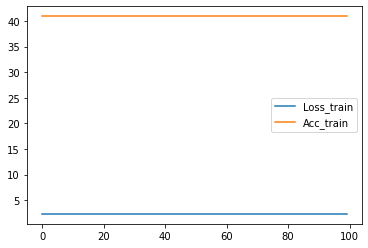

In [50]:
# Phase apprentissage
model = Model2LP(dim_in=784, l=200, dim_out=10)

# Phase train
v = True # verbose
list_loss = []
liste_acc = []
for epoch in range(100):
  loss_epoch = []
  acc_epoch = []
  for batch_idx, batch in enumerate(train_loader):
    
      logs = model.training_step(batch, batch_idx)

      if v and batch_idx % 1 == 0:
        courant = batch_idx * len(batch)
        #print(f"loss: {logs['loss']:>7f} acc: {logs['accuracy']:>7f} len: {logs['nb']:>7f}")

      loss_epoch.append(logs['loss'].detach())
      acc_epoch.append(logs['accuracy'].detach())

  list_loss.append(np.mean(loss_epoch))
  liste_acc.append(np.mean(acc_epoch))

    
    
plt.plot(list_loss,label="Loss_train")
plt.plot(liste_acc,label="Acc_train")
plt.legend()
plt.show()

In [48]:
import numpy as np

In [37]:
dim_in = 784
dim_latent = 100
dim_out = 10
train_length =  50

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
epoch = 10
dim_latent = 100
model = MLP3(dim_in,dim_latent,dim_out).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
soft = nn.Softmax(dim=1)

def train(train_loader, model, optimizer, epoch, device):
    loss_train = []
    loss_test = []
    acc_train = []
    acc_test = []
    for e in range(epoch):
        model.train()
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output,target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                    f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                loss_train.append(loss.item())
                acc_train.append((soft(output).argmax(1)==target).sum()/len(target))
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=len(test_loader)):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.cross_entropy(output,target)
                if batch_idx % 10 == 0:
                    print(f'Test Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                        f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                    loss_test.append(loss.item())
                    acc_test.append((soft(output).argmax(1)==target).sum()/len(target))
    return loss_train, loss_test, acc_train, acc_test

loss_train, loss_test, acc_train, acc_test = train(train_loader, model, optimizer, epoch, device)

plt.plot(loss_train,label="Loss_train")
plt.plot(loss_test,label="Loss_test")
plt.plot(acc_train,label="Acc_train")
plt.plot(acc_test,label="Acc_test")
plt.legend()
plt.show()

cpu


TypeError: MLP3.__init__() takes 1 positional argument but 4 were given